# Imports

In [11]:
from NanoParticleTools.inputs.nanoparticle import SphericalConstraint
from NanoParticleTools.flows.flows import get_npmc_flow
from NanoParticleTools.builder import UCNPBuilder
from NanoParticleTools.util.visualization import plot_nanoparticle

from jobflow import run_locally
from maggma.stores import MemoryStore
from jobflow import JobStore

from matplotlib import pyplot as plt
import numpy as np
import logging

In [12]:
# Define a core only nanoparticle with a radius of 15\AA{} (d=3nm)
constraints = [SphericalConstraint(15)]
# Dope the (Y sites of the) core with 1% Er3+ and 99% Yb3+
dopant_specifications = [(0, 0.01, 'Er', 'Y'), (0, 0.99, 'Yb', 'Y')]

#
spectral_kinetics_args = {
    'excitation_wavelength': 980,  # wavelenth in nm
    'excitation_power': 1e5  # Power in W*cm^-2
}

npmc_args = {'npmc_command': 'NPMC',
             'num_sims':16,
             'base_seed': 1000,
             'thread_count': 2,
             'simulation_length': 100000,
             }

flow = get_npmc_flow(
    constraints=constraints,
    dopant_specifications=dopant_specifications,
    doping_seed=0,
    output_dir='.scratch',
    initial_states=None,  # Use ground state
    override=False,
    spectral_kinetics_args=spectral_kinetics_args,
    npmc_args=npmc_args,
    metadata={'type': 'example'})

# Plot the nanoparticle

Here, we are running a simulation for a 3nm diameter nanoparticle.\
The nanoparticle is formed from a NaYF<sub>4</sub> host, with Yb \
and Er doped on the Y sites.

The nanoparticle is to be excited with 980nm light at a power of \
100,000 W/cm<sup>2</sup>.

We simulate for 100k steps, although for production, we recommend \
at least 20M steps or a total of 10 milliseconds.

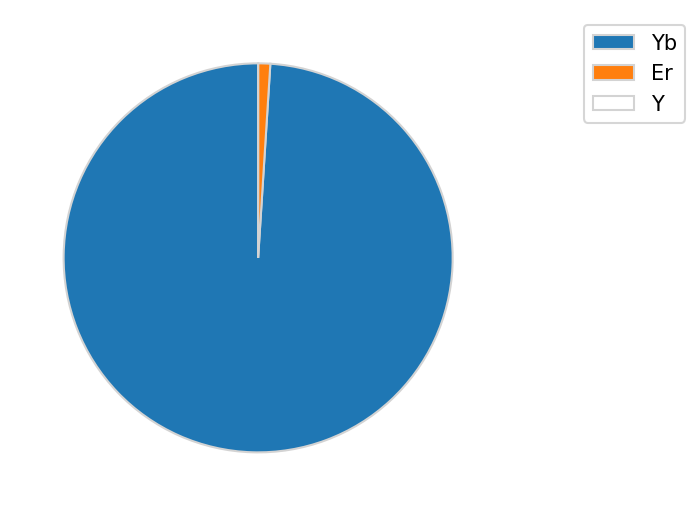

In [30]:
plot_nanoparticle(constraints, dopant_specifications=dopant_specifications, elements=['Yb', 'Er'])
plt.show()

# Run the simulation

In [8]:
# Store the output data locally in a MemoryStore
docs_store = MemoryStore()
data_store = MemoryStore()
store = JobStore(docs_store, additional_stores={'trajectories': data_store})

responses = run_locally(flow, store=store, ensure_success=True)

2024-01-16 14:30:38,649 INFO Started executing jobs locally
2024-01-16 14:30:38,649 - jobflow.managers.local - INFO - Started executing jobs locally
2024-01-16 14:30:38,651 INFO Starting job - npmc_job (fd6ec1ee-151a-4d94-9253-9578a44c8768)
2024-01-16 14:30:38,651 - jobflow.core.job - INFO - Starting job - npmc_job (fd6ec1ee-151a-4d94-9253-9578a44c8768)
Running NPMC using the command: "NPMC --nano_particle_database=.scratch/np.sqlite --initial_state_database=.scratch/initial_state.sqlite --number_of_simulations=16 --base_seed=1000 --thread_count=2 --step_cutoff=100000"
2024-01-16 14:37:20,800 INFO Finished job - npmc_job (fd6ec1ee-151a-4d94-9253-9578a44c8768)
2024-01-16 14:37:20,800 - jobflow.core.job - INFO - Finished job - npmc_job (fd6ec1ee-151a-4d94-9253-9578a44c8768)
2024-01-16 14:37:20,803 INFO Finished executing jobs locally
2024-01-16 14:37:20,803 - jobflow.managers.local - INFO - Finished executing jobs locally


# Run the builder to average the results

In [9]:
avg_sim_store = MemoryStore()

builder = UCNPBuilder(data_store, avg_sim_store)
builder.run(logging.CRITICAL)

1it [00:00, 13.65it/s]


# Plot the spectra for this simulation

Now we plot the emissions to check if there are UV emissions

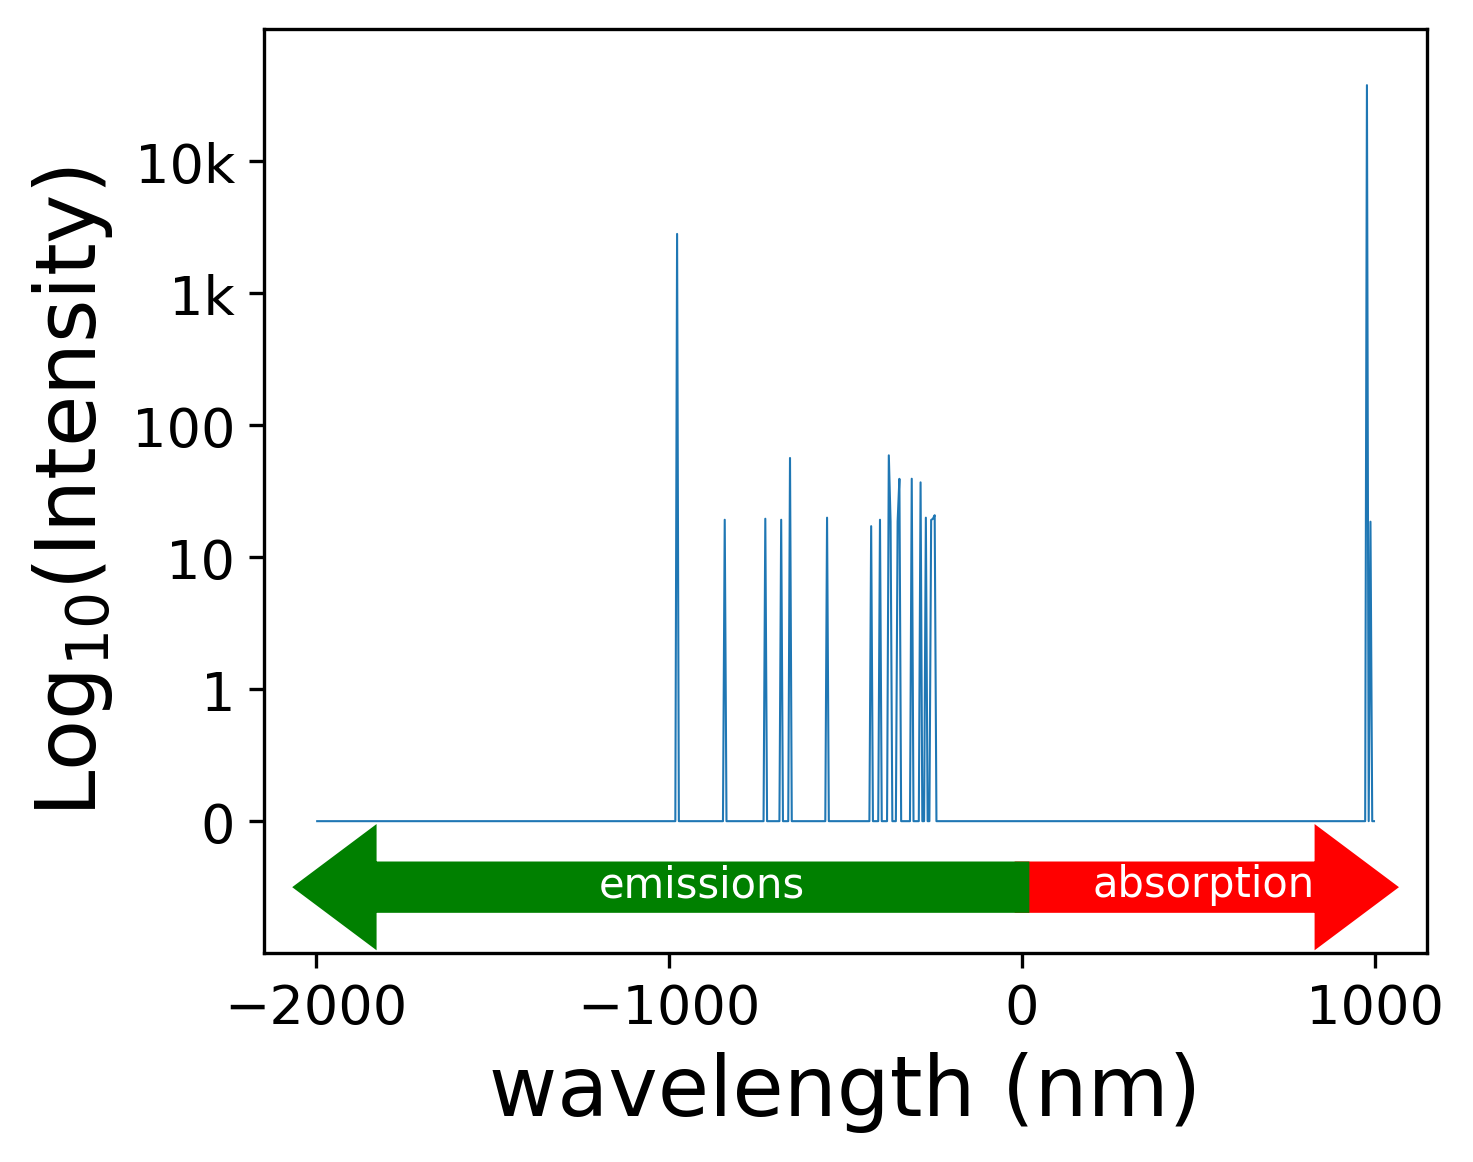

In [29]:
doc = avg_sim_store.query_one()

x = doc['output']['wavelength_spectrum_x']
y = doc['output']['wavelength_spectrum_y']
plt.figure(dpi=300, figsize=(5, 4))
plt.plot(x, np.log10(np.add(y, 1)), linewidth=0.5)
plt.arrow(50,
          -0.5,
          900,
          0,
          width=.01,
          head_width=.2,
          head_length=50,
          lw=12,
          color='red',
          length_includes_head=True)
plt.arrow(-50,
          -0.5,
          -1900,
          0,
          width=.01,
          head_width=.2,
          head_length=50,
          lw=12,
          color='green',
          length_includes_head=True)
plt.text(200, -0.57, 'absorption', color='white')
plt.text(-1200, -0.57, 'emissions', color='white')
plt.ylim(-1, 6)
plt.xticks([-2000, -1000, 0, 1000], fontsize=13)
plt.yticks([0, 1, 2, 3, 4, 5], ['0', '1', '10', '100', '1k', '10k'], fontsize=13)
plt.xlabel('wavelength (nm)', fontsize=20)
plt.ylabel('Log$_{10}$(Intensity)', fontsize=20)
plt.show()

It looks like the particle does emit in the UV region, given the laser conditions.